# 2024-026 Peak Filtering

This notebook details methods to select high quality peaks from consensus peaks directly from nf-core/atac-seq.

## Initialize Environment

In [1]:
# Load libraries
library(dplyr)
library(tidyr)
library(ggplot2)

# Load data
exp_dir     <- "/home/dalbao/2024-026-Tcf7ATAC"
nfcore_dir  <- "01_nfcore_241228"
nb_dir      <- "02_bp_notebooks"
prefix      <- "peakFilter"                                # bp for broad peak calling settings

# nf-core ATAC-seq pipeline calls peaks from two different libraries:
library     <- "merged_library"
# If library == merged_library, lib_sh is mLb
# else if it is == merged_replicates, lib_sh is mRp
lib_sh      <- ifelse(library == "merged_library", "mLb", "mRp")

# nf-core ATAC-seq pipeline calls peaks in two types, broad_peak and narrow_peak:
peak_type   <- "broad_peak"
# If peak_type == broad_peak, peak_sh is bp
peak_sh     <- ifelse(peak_type == "broad_peak", "bp", "np")

# Add peak type and date to prefix
prefix <- paste0(format(Sys.Date(), "%y%m%d"), "-", peak_sh, "-", prefix)

# Move to working directory
setwd(exp_dir)

# Load merged library consensus peaks boolean matrix
peaks_file <- paste("consensus_peaks", lib_sh, "clN.boolean.txt", sep = ".")
peaks <- read.table(paste(      nfcore_dir,
                                "bwa",
                                library,
                                "macs2/",
                                peak_type,
                                "/consensus",
                                peaks_file,
                                sep = "/"),
                    header = TRUE, sep = "\t")

# Preview
head(peaks[, 1:8])


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,chr,start,end,interval_id,num_peaks,num_samples,CX3CR1pos_shCD19_REP1.mLb.clN.bool,CX3CR1pos_shCD19_REP2.mLb.clN.bool
,<chr>,<int>,<int>,<chr>,<int>,<int>,<lgl>,<lgl>
1,1,3008716,3009098,Interval_1,1,1,FALSE,FALSE
2,1,3026196,3027005,Interval_2,2,2,FALSE,FALSE
3,1,3062293,3062545,Interval_3,1,1,FALSE,FALSE
4,1,3062944,3063216,Interval_4,1,1,FALSE,FALSE
5,1,3063383,3064024,Interval_5,1,1,FALSE,FALSE
6,1,3084438,3085013,Interval_6,2,2,FALSE,FALSE


## Manipulate Boolean Matrix

Manipulate the boolean matrix to a point where it can be analysed. First check for Y chromosome regions then remove if present.


    1    10    11    12    13    14    15    16    17    18    19     2     3 
23397 16743 11831 13078 13361 15008 10387 14003 11507  9171  4682 22713 19479 
    4     5     6     7     8     9     X     Y 
16919 16717 18471 14053 14055 12716  7094    32 

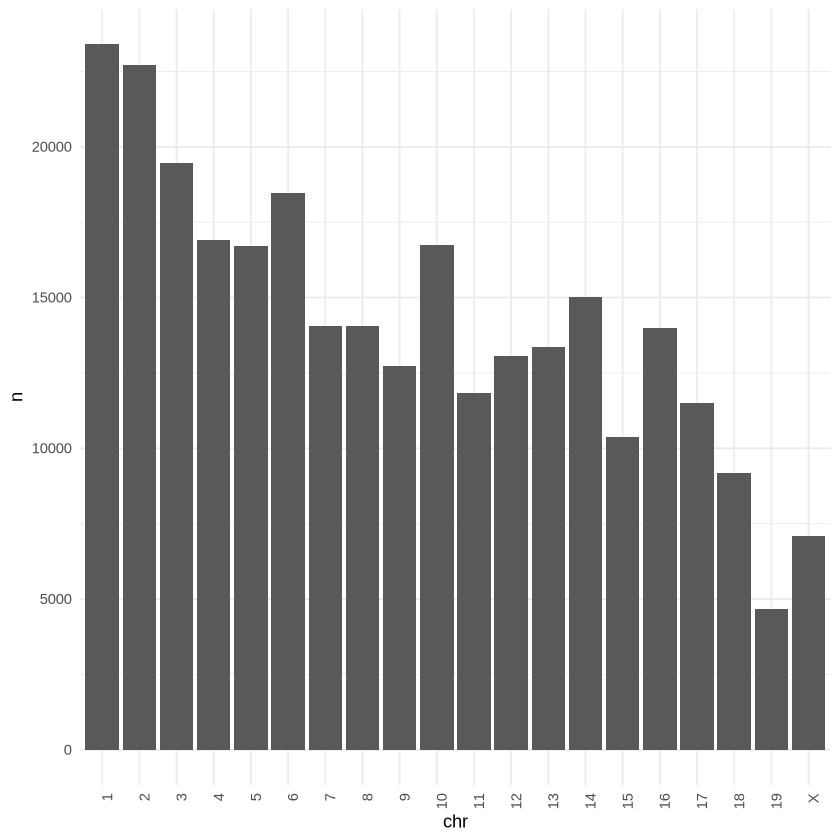

In [2]:
# Check if Y chomosome is present
table(peaks$chr)

# Remove Y chromosome
peaks <- peaks[peaks$chr != "Y", ]


# Factorize chromosome column
peaks$chr <- factor(peaks$chr, levels = c(1:19, "X"))

# Backup
.peaks <- peaks

# Plot distribution of peaks per chromosome
peaks %>%
    group_by(chr) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = chr, y = n)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

Isolate first six columns as metadata:

In [3]:
# Isolate metadata columns
peak_metadata <- peaks[, 1:6]

# Rename rows as Interval IDs
rownames(peak_metadata) <- peaks$interval_id
rownames(peaks) <- peaks$interval_id

# Keep only peak columns with bool in the name
peaks <- peaks[, grepl("bool", colnames(peaks))]
peaks_suffix <- paste0(".", lib_sh, ".clN.bool")
# Remove pattern from column names
colnames(peaks) <- gsub(peaks_suffix, "", colnames(peaks))

# Transpose matrix
peaks <- t(peaks)

# Preview
head(peak_metadata)
head(peaks[, 1:4])

,chr,start,end,interval_id,num_peaks,num_samples
,<fct>,<int>,<int>,<chr>,<int>,<int>
Interval_1,1,3008716,3009098,Interval_1,1,1
Interval_2,1,3026196,3027005,Interval_2,2,2
Interval_3,1,3062293,3062545,Interval_3,1,1
Interval_4,1,3062944,3063216,Interval_4,1,1
Interval_5,1,3063383,3064024,Interval_5,1,1
Interval_6,1,3084438,3085013,Interval_6,2,2


,Interval_1,Interval_2,Interval_3,Interval_4
CX3CR1pos_shCD19_REP1,FALSE,FALSE,FALSE,FALSE
CX3CR1pos_shCD19_REP2,FALSE,FALSE,FALSE,FALSE
CX3CR1pos_shRunx3_REP1,FALSE,FALSE,FALSE,FALSE
CX3CR1pos_shRunx3_REP2,FALSE,FALSE,FALSE,FALSE
D5_shCD19_REP1,FALSE,FALSE,FALSE,FALSE
D5_shCD19_REP2,FALSE,FALSE,FALSE,FALSE


## Load Sample Metadata

In [4]:
# Load sample metadata
sample_metadata <- read.csv("metadata/sampleInfo.csv")

# Make sure that the of sampleMetadata (as defined by the 'sample' column)
# is the same order as the column names of the peaks matrix
sample_metadata <- sample_metadata[match(rownames(peaks), sample_metadata$sample), ]

# Confirm one-to-one correspondence
all(rownames(peaks) == sample_metadata$sample)

# View head
head(sample_metadata)

[1] TRUE

,condition,replicate,sample,experiment
,<chr>,<int>,<chr>,<chr>
3,CX3CR1pos_shCD19,1,CX3CR1pos_shCD19_REP1,DA
9,CX3CR1pos_shCD19,2,CX3CR1pos_shCD19_REP2,DA
6,CX3CR1pos_shRunx3,1,CX3CR1pos_shRunx3_REP1,DA
12,CX3CR1pos_shRunx3,2,CX3CR1pos_shRunx3_REP2,DA
15,D5_shCD19,1,D5_shCD19_REP1,ST
17,D5_shCD19,2,D5_shCD19_REP2,ST


## Define Functions

Define a function to count the number of times a peak is called "TRUE" per group/experiment.

In [5]:
#' Summarize Peak Counts by Group
#'
#' This function takes a logical matrix of peak occurrences and a vector of group labels,
#' and returns a summary matrix with the count of TRUE values (peaks) for each group and column.
#'
#' @param peak_matrix A logical matrix where rows represent peaks and columns represent samples.
#'                    Each element should be TRUE if a peak is present and FALSE otherwise.
#' @param group_vector A vector of group labels corresponding to each row of the peak_matrix.
#'                     The length of this vector should be equal to the number of rows in peak_matrix.
#'
#' @return A matrix where rows represent groups and columns represent samples.
#'         Each element in the matrix is the count of TRUE values (peaks) for the corresponding group and sample.
#'
#' @examples
#' # Example usage:
#' peak_matrix <- matrix(c(TRUE, FALSE, TRUE, TRUE, FALSE, TRUE, FALSE, FALSE, TRUE), nrow = 3, byrow = TRUE)
#' group_vector <- c("Group1", "Group2", "Group1")
#' summarize_peak_counts(peak_matrix, group_vector)
#'
#' @export
summarize_peak_counts <- function(peak_matrix, group_vector) {
    # Split the row indices of the matrix by condition
    groups <- split(1:nrow(peak_matrix), group_vector)

    # Apply the function to calculate the sum of TRUE values per column for each group
    grouped_true_counts <- lapply(groups, function(indices) {
        # Subset rows corresponding to the group
        group_matrix <- peak_matrix[indices, , drop = FALSE]
        # Count TRUE values in each column
        apply(group_matrix, 2, function(column) sum(column == TRUE))
    })

    # Convert the list into a data frame
    summary_df <- do.call(rbind, grouped_true_counts)

    # Set row names as group names
    rownames(summary_df) <- names(grouped_true_counts)

    # Convert to integer matrix
    summary_df <- as.matrix(summary_df)
    mode(summary_df) <- "integer"

    # Return the resulting matrix
    return(summary_df)
}

## Select High Quality, Cross-Experiment Peaks

This portion of the notebook details processes for the selection of high-quality peaks that carry-over to multiple independent experiments.

### SELECTION PARAMETERS

These are the selection parameters for identifying high quality peaks.

In [6]:
# frac_rep is the proportion of replicates that must have a peak called
# to be considered "observed" within an experimental condition/group.
frac_rep <- 0.75

# num_exps is the number of experiments that countain at least one condition/group
# that observed the a peak for it to be considered to carry-over to multiple experiments.
num_exps <- 3

### Identify Conditions/Groups that Observe a Peak

To observe a peak, the number of replicates that call a specific peak within a condition/group must surpass frac_rep.

In [7]:
# Confirm one-to-one correspondence
all(rownames(peaks) == sample_metadata$sample)

# Summarize peak calls by group
peakCalls_per_group <- summarize_peak_counts(peaks, sample_metadata$condition)

[1] TRUE

In [8]:
# Check the data
head(peakCalls_per_group[, 1:15])

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,Interval_11,Interval_12,Interval_13,Interval_14,Interval_15
CX3CR1pos_shCD19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CX3CR1pos_shRunx3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D5_shCD19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D5_shRunx3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dpf_naive,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
DW_RUNX3KO_0h,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Identify the size of each experimental group/condition
group_size <- as.integer(table(sample_metadata$condition))
names(group_size) <- names(table(sample_metadata$condition))

# Check one-to-one correspondence
all(rownames(peakCalls_per_group) == names(group_size))

# Divide each row of peakCalls_per_group by the corresponding value in group_size
fraction.peakCalls_per_group <- sweep(peakCalls_per_group, 1, group_size, FUN = "/")

# Determine which conditions "observed" a peak, defined by having at least frac_rep of replicates with a peak called
observed_peaks <- fraction.peakCalls_per_group >= frac_rep

# Check the data
head(observed_peaks[, 1:15])

[1] TRUE

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,Interval_11,Interval_12,Interval_13,Interval_14,Interval_15
CX3CR1pos_shCD19,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
CX3CR1pos_shRunx3,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
D5_shCD19,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
D5_shRunx3,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
dpf_naive,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
DW_RUNX3KO_0h,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


### Determine Experimental Carry-Over

A peak is considered "high quality" if it is observed in at least one group/condition in at least three independent experiments.

In [10]:
# Collapse the sampleMetadata into only condition - experiment pairs
experiment_metadata <- sample_metadata[, c("condition", "experiment")]
experiment_metadata <- unique(experiment_metadata)

# Check one-to-one correspondence
# Match observations of experiment_metadata (identified by the column condition)
# with the rownames of observed_peaks
experiment_metadata <- experiment_metadata[match(rownames(observed_peaks), experiment_metadata$condition), ]

# Check one-to-one correspondence
all(rownames(observed_peaks) == experiment_metadata$condition)
experiment_metadata

[1] TRUE

,condition,experiment
,<chr>,<chr>
3,CX3CR1pos_shCD19,DA
6,CX3CR1pos_shRunx3,DA
15,D5_shCD19,ST
16,D5_shRunx3,ST
58,dpf_naive,DPF
20,DW_RUNX3KO_0h,DW
26,DW_RUNX3KO_12h,DW
28,DW_RUNX3KO_24h,DW
22,DW_RUNX3KO_2h,DW


In [11]:
# Summarize the number of groups that observed a peak for each experiment
expeirment_counts <- summarize_peak_counts(observed_peaks, experiment_metadata$experiment)

# Check the data
head(expeirment_counts[, 1:15])

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,Interval_11,Interval_12,Interval_13,Interval_14,Interval_15
DA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DPF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
JSB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# A peak is observed in an experiment if it is observed in at least one sample/group
observed.experiment_peaks <- expeirment_counts > 0

# Check the data
head(observed.experiment_peaks[, 1:15])

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,Interval_11,Interval_12,Interval_13,Interval_14,Interval_15
DA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
DPF,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
DW,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
JSB,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
OK,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
ST,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


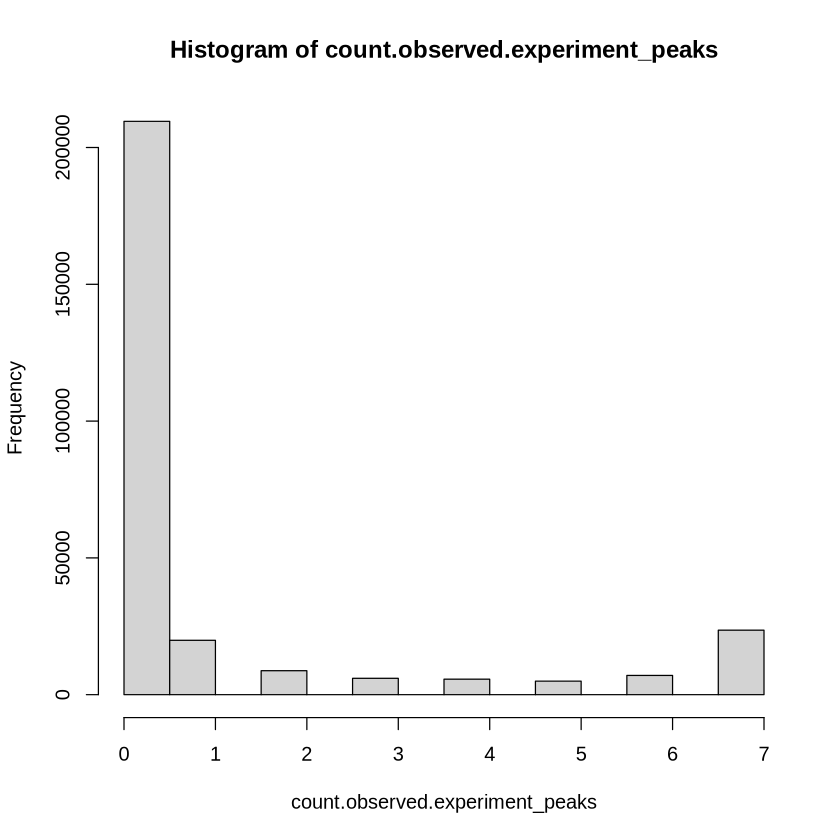

In [13]:
# Count the number of true per column
count.observed.experiment_peaks <- colSums(observed.experiment_peaks)

# Check distribution of observed peaks per experiment
hist(count.observed.experiment_peaks)

In [14]:
# Keep peaks that are observed in at least num_exps experiments
keep_peak <- count.observed.experiment_peaks >= num_exps

# Count the number of peaks that are kept
sum(keep_peak)
keep_peak[1:5]

[1] 47192

Interval_1 Interval_2 Interval_3 Interval_4 Interval_5 
     FALSE      FALSE      FALSE      FALSE      FALSE

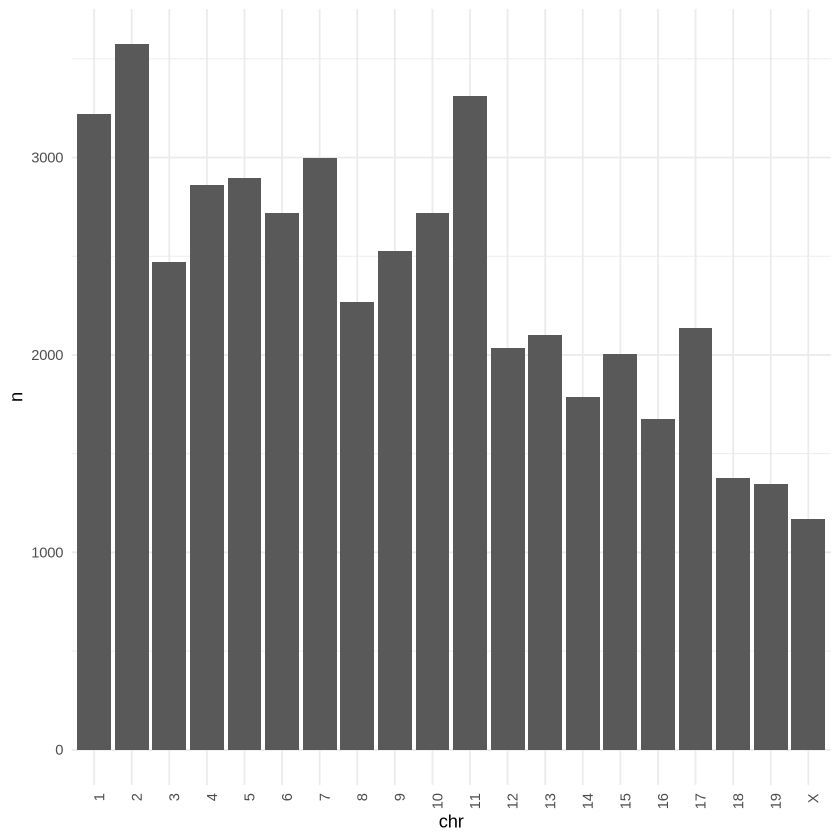

In [15]:
# Plot the distribution of kept peaks per chromosome
peaks <- .peaks[keep_peak,]
peaks %>%
    group_by(chr) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = chr, y = n)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Save Data

In [16]:
# Make sure that keep_peak is in the same order as the rows of peaks_metadata
keep_peak <- keep_peak[match(rownames(peak_metadata), names(keep_peak))]

# Check one-to-one correspondence
all(rownames(peak_metadata) == names(keep_peak))

[1] TRUE

In [17]:
# Add a column to peak_metadata indicating if the peak is kept
peak_metadata$keep_peak <- keep_peak

# Remove num_peaks and num_samples columns
peak_metadata <- peak_metadata[, -c(5, 6)]

# Check the data
head(peak_metadata)

,chr,start,end,interval_id,keep_peak
,<fct>,<int>,<int>,<chr>,<lgl>
Interval_1,1,3008716,3009098,Interval_1,FALSE
Interval_2,1,3026196,3027005,Interval_2,FALSE
Interval_3,1,3062293,3062545,Interval_3,FALSE
Interval_4,1,3062944,3063216,Interval_4,FALSE
Interval_5,1,3063383,3064024,Interval_5,FALSE
Interval_6,1,3084438,3085013,Interval_6,FALSE


In [18]:
# File name for peak filtering data
save_file <- paste( nfcore_dir, "/",
                    prefix,
                    ".txt",
                    sep = "")

# Save peak filtering file
write.table(peak_metadata,
            file = save_file,
            sep = "\t", quote = FALSE, row.names = FALSE)

# File name for consensus peaks
consensus_file <- paste("consensus_peaks", lib_sh, "clN.bed", sep = ".")
consensus_loc  <- paste(   nfcore_dir,
                            "bwa",
                            library,
                            "macs2",
                            peak_type,
                            "consensus",
                            consensus_file,
                            sep = "/")

# File name for filtered bed file
filtered_file <- paste( nfcore_dir, "/",
                        format(Sys.Date(), "%y%m%d"), "-filtered-",
                        lib_sh,
                        ".bed",
                        sep = "")

format(Sys.Date(), "%y%m%d")

# Prepare system command to run bed_keeper.pl
sys <- paste(   "perl 00_scripts/bed_keeper.pl",
                save_file,
                consensus_loc,
                ">",
                filtered_file)
# Run bed_keeper.pl
cat("Running bed_keeper.pl\n")
cat(sys, "\n")
system(sys)

[1] "241231"

Running bed_keeper.pl
perl 00_scripts/bed_keeper.pl 01_nfcore_241228/241231-bp-peakFilter.txt 01_nfcore_241228/bwa/merged_library/macs2/broad_peak/consensus/consensus_peaks.mLb.clN.bed > 01_nfcore_241228/241231-filtered-mLb.bed 
